# Project 2
### Objective: Forecasting the price for a given product of a company in a univariate or multivariate setting (with information respecting the market competitors). 

### Importing packages

In [6]:
import os
import math
import numpy as np
import pandas as pd
from datetime import datetime
import time
import pickle

import seaborn as sns
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
import tensorflow as tf
from tensorflow import keras

from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf
from sklearn.metrics import mean_squared_error
from math import sqrt
from tqdm import tqdm_notebook


import warnings
warnings.filterwarnings('ignore')


from itertools import product

In [7]:
bestX = []
bestY = []
bestparameters = []

In [8]:
def dickey_fuller_test(time_series):
    result = adfuller(time_series)
    print("ADF Test Statistic: ", result[0])
    print("P-value: ", result[1])
    critical_values = result[4] 
    if result[0] < critical_values["5%"]:
        print("Reject the null hypothesis - Time Series is stationary")
        return 1
    else:
        print("Failed to reject the null hypothesis - Time Series is not stationary")
        return 0
    return 0

    

def kpss_test(time_series):
    kpss_stat, p_value, lags, crit = kpss(time_series, 'c')
    print("KPSS Test Statistic: ", kpss_stat)
    print("P-value: ", p_value)
    if p_value < 0.05:
        print("Reject the null hypothesis - Time Series is stationary")
        return 1
    else:
        print("Failed to reject the null hypothesis - Time Series is not stationary")
        return 0
    return 0


### Importing data

In [12]:
product_group_id = 958
data_wide = pd.read_pickle("time_series/Data/time_series_1/wide_product_group_id_" + str(product_group_id))
data = data_wide.iloc[:,0]
data

if os.path.isdir('figures') == False:
    os.mkdir("figures")

In [10]:
data_wide.columns

Index(['Abcdin', 'Falabella', 'Lider', 'Paris', 'Ripley', 'claro', 'entel',
       'movistar', 'wom', 'vtr', 'macOnline'],
      dtype='object')

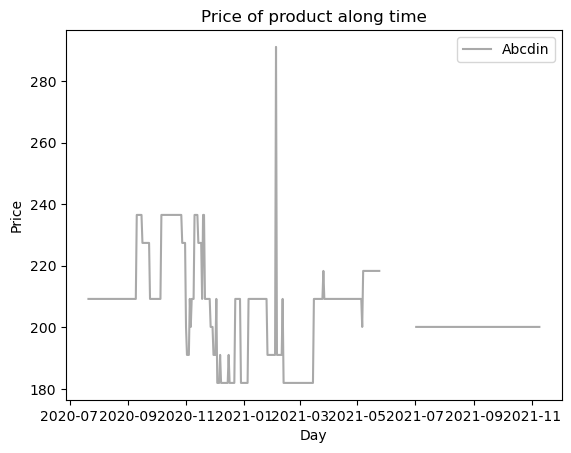

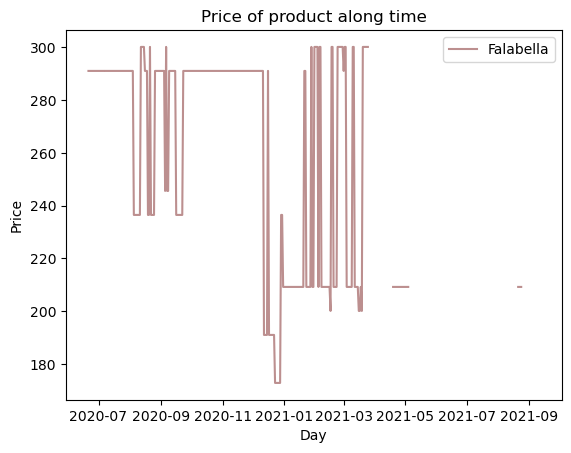

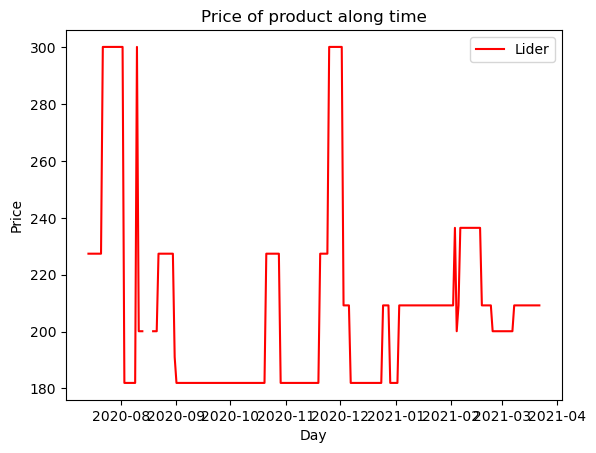

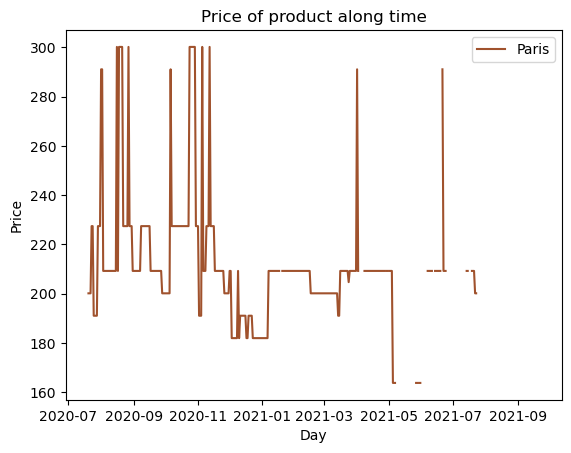

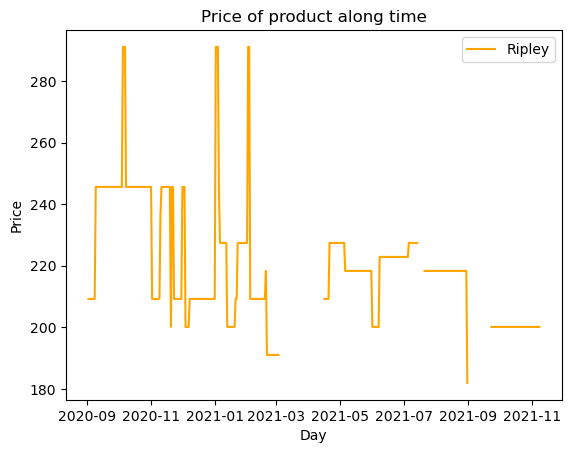

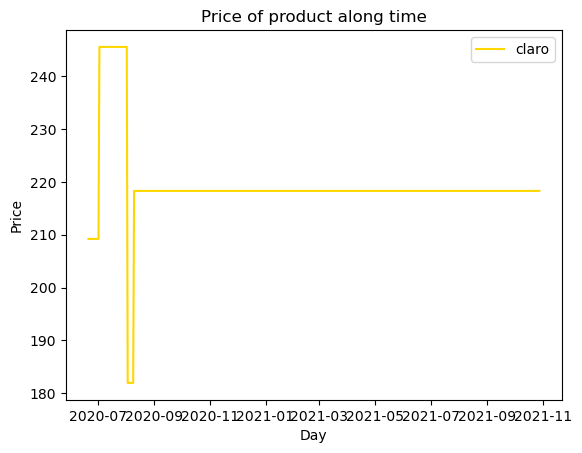

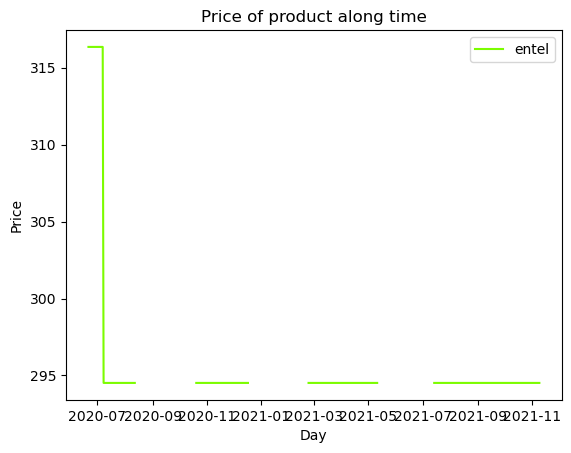

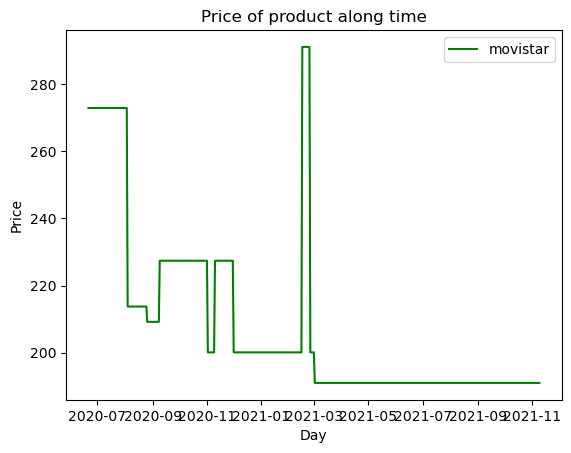

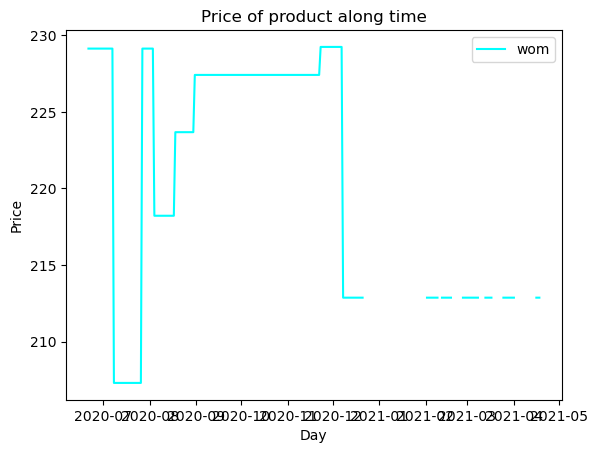

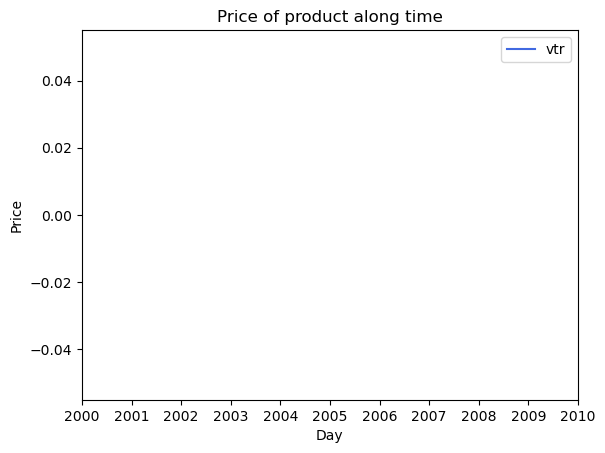

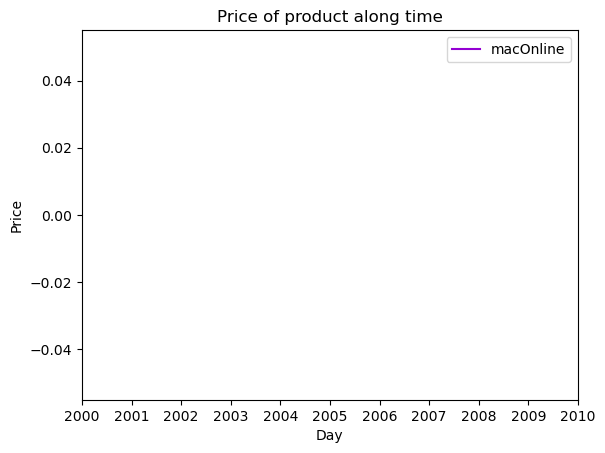

In [46]:
X = data_wide.index
colors = ["darkgray", "rosybrown", "red", "sienna", "orange", "gold", "lawngreen", "green", "cyan", "royalblue", "darkviolet"]
data_wide.head()
legend = []
for company, color in zip(data_wide.columns, colors):
    plt.figure()
    plt.plot(data_wide[company], color=color)
    plt.title("Price of product along time")
    plt.legend([company])
    plt.ylabel('Price')
    plt.xlabel('Day')
    plt.savefig("figures/"+company+"_data_plots.jpeg", bbox_inches="tight")
    plt.show()
    

### Pre processamente do dataset
Caso os dados iniciais do dataset tenham valores em falta iremos remover esses dados do dataset, e posteriormente isto iremos preencher valores que estejam em falta ao longo da série temporal. 

In [47]:
for i in range(len(data)):
    if (math.isnan(data[i]) == False):
        data = data[i:]
        break;

In [48]:
data

2020-07-21    209.214955
2020-07-22    209.214955
2020-07-23    209.214955
2020-07-24    209.214955
2020-07-25    209.214955
                 ...    
2021-11-05    200.118257
2021-11-06    200.118257
2021-11-07    200.118257
2021-11-08    200.118257
2021-11-09    200.118257
Freq: D, Name: Abcdin, Length: 477, dtype: float64

In [ ]:
data1 = data.interpolate()

In [ ]:
for i in range(len(data)):
    print(data[i],":",data1[i])

Definição de funções para fazer samples através de uma sequência

In [ ]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

# split a multivariate sequence into samples
def multi_split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
    # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [ ]:
n_steps = 3
n_features = 1

In [ ]:
X, y = split_sequence(data1, n_steps)
for i in range(len(X)):
    print(X[i], y[i])

In [ ]:
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [ ]:
model.fit(X, y, epochs=200, verbose=0)

In [ ]:
for i in range(X.shape[0]):
    x_input = X[i].reshape((1, n_steps, n_features))
    yhat = model.predict(x_input, verbose=0)
    print(yhat,":",y[i])

## Univariate

### Vanilla LSTM
Iremos variar o número de steps, para encontrar os hiperparâmetros que construir o modelo que tem a melhor performance, tendo em conta o nosso objetivo

In [ ]:
min_error = 1000000000000000
best_steps = 0
best_X_train = []
best_X_test = []
best_y_train = []
best_y_test = []

for n_steps in range (3,20,4):
    
    n_features = 1
    X, y = split_sequence(data1, n_steps)
    train_ind = int(X.shape[0]*0.7)
    X_train = X[:train_ind]
    y_train = y[:train_ind]
    X_test = X[train_ind:]
    y_test = y[train_ind:]
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=200, verbose=0)
    mspe = np.zeros((X.shape[0],1))
    for i in range(X_test.shape[0]):
        x_input = X_test[i].reshape((1, n_steps, n_features))
        yhat = model.predict(x_input, verbose=0)
        mspe[i] = (yhat-y_test[i])**2
    error = np.sum(mspe)
    if error < min_error:
        model.save("best_vanilla_lstm")
        min_error = error
        best_steps = n_steps
        best_X_train = X_train
        best_X_test = X_test
        best_y_train = y_train
        best_y_test = y_test
    print("Steps: ", n_steps, "\tErro: ", error)

Construção do modelo vanilla LSTM com os melhores parâmetros que foram calculados previamente

In [ ]:
n_features = 1
best_vanilla_model = keras.models.load_model("best_vanilla_lstm")
predictions = np.zeros((best_X_test.shape[0],1))
for i in range(best_X_test.shape[0]):
    x_input = best_X_test[i].reshape((1, best_steps, n_features))
    yhat = best_vanilla_model.predict(x_input, verbose=0)
    mspe[i] = (yhat-best_y_test[i])**2
    predictions[i] = yhat
error = np.sum(mspe)
print(error)

In [ ]:
X_test = np.ones((best_X_test.shape[0],1))
for i in range(best_X_test.shape[0]-1):
        X_test[i] = best_X_test[i][best_steps-1]

In [ ]:
plt.plot(X_test,best_y_test)
plt.plot(X_test,predictions)
plt.title('Vanilla Model')
plt.ylabel('Price')
plt.xlabel('Time')
plt.legend(['Real Value', 'Prediction'], loc='upper left')
plt.savefig('figures/vanilla_lstm.png')
plt.show()

### Stacked LSTM
Iremos encontrar o modelo que tem a melhor performance, variando o número de steps e a quantidade de hidden layers para encontrar os melhores hiperparâmetros

In [ ]:
min_error = 1000000000000000
best_steps = 0
best_n_layers = 0
for n_steps in range (3,20,4):
    n_features = 1
    X, y = split_sequence(data1, n_steps)
    train_ind = int(X.shape[0]*0.7)
    X_train = X[:train_ind]
    y_train = y[:train_ind]
    X_test = X[train_ind:]
    y_test = y[train_ind:]
    for num_layers in range(2,6):
        model = Sequential()
        model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
        for k in range(num_layers-1):
            model.add(LSTM(50, activation='relu', return_sequences=True))
            n_layer = k+1
        model.add(LSTM(50, activation='relu'))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')
        model.fit(X_train, y_train, epochs=200, verbose=0)
        mspe = np.zeros((X.shape[0],1))
        for i in range(X_test.shape[0]):
            x_input = X_test[i].reshape((1, n_steps, n_features))
            yhat = model.predict(x_input, verbose=0)
            mspe[i] = (yhat-y_test[i])**2
        error = np.sum(mspe)
        if error < min_error:
            model.save("best_stacked_lstm")
            min_error = error
            best_steps = n_steps
            best_n_layers = n_layer
            best_steps = n_steps
            best_X_train = X_train
            best_X_test = X_test
            best_y_train = y_train
            best_y_test = y_test
        print("Steps: ",n_steps, "\tNúmero de layers: ", num_layers,"\tErro: ", error)

Construção do modelo Stacked LSTM com os melhores hiperparâmetros

In [ ]:
n_features = 1
best_vanilla_model = keras.models.load_model("best_stacked_lstm")
predictions = np.zeros((best_X_test.shape[0],1))
for i in range(best_X_test.shape[0]):
    x_input = best_X_test[i].reshape((1, best_steps, n_features))
    yhat = best_vanilla_model.predict(x_input, verbose=0)
    mspe[i] = (yhat-best_y_test[i])**2
    predictions[i] = yhat
error = np.sum(mspe)
print(error)

In [ ]:
X_test = np.ones((best_X_test.shape[0],1))
for i in range(best_X_test.shape[0]-1):
        X_test[i] = best_X_test[i][best_steps-1]

# Agora iremos implementar o modelo ARIMA 

In [13]:
product_group_id = 958
data_wide = pd.read_pickle("time_series/Data/time_series_1/wide_product_group_id_" + str(product_group_id))
data = data_wide.iloc[:,[0,1]]


if os.path.isdir('figures') == False:
    os.mkdir("figures")
data.rename(columns={'Falabella':'Forecast'}, inplace=True)
data.rename(columns={'Abcdin':'data'}, inplace=True)
data['Forecast_log']=data['data'].values
data.head()



,data,Forecast,Forecast_log
2020-06-21,NaN,291.085236,NaN
2020-06-22,NaN,291.085236,NaN
2020-06-23,NaN,291.085236,NaN
2020-06-24,NaN,291.085236,NaN
2020-06-25,NaN,291.085236,NaN


(array([18444., 18506., 18567., 18628., 18687., 18748., 18809., 18871.,
        18932.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

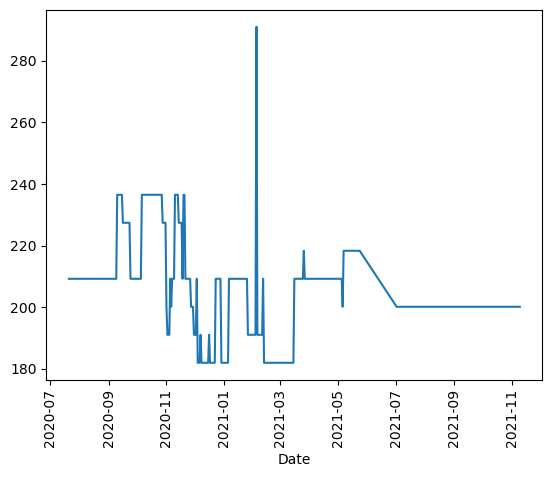

In [14]:
for i in range(len(data['data'])):
    if (math.isnan(data['data'][i]) == False):
        data = data.iloc[i:]
        break;


data['data'] = data['data'].interpolate()
plt.plot(data['data'])
plt.xlabel('Date')
plt.xticks(rotation=90)



In [15]:
msk = (data['data'].index < '2021-06-01')
data_train = data['data'][msk].copy()
data_test = data['data'][~msk].copy()



2020-07-21    209.214955
2020-07-22    209.214955
2020-07-23    209.214955
2020-07-24    209.214955
2020-07-25    209.214955
                 ...    
2021-05-27    216.912161
2021-05-28    216.445664
2021-05-29    215.979166
2021-05-30    215.512669
2021-05-31    215.046172
Freq: D, Name: data, Length: 315, dtype: float64

DADOS ORIGINAIS

ADF Test Statistic:  -3.2913856786258244
P-value:  0.015267953572002627
Reject the null hypothesis - Time Series is stationary
KPSS Test Statistic:  0.554307889590071
P-value:  0.029435160002236244
Reject the null hypothesis - Time Series is stationary

 Primeira diferêncial

ADF Test Statistic:  -17.34965108906464
P-value:  5.280482333318879e-30
Reject the null hypothesis - Time Series is stationary
KPSS Test Statistic:  0.047314536357915805
P-value:  0.1
Failed to reject the null hypothesis - Time Series is not stationary

Segunda diferêncial

ADF Test Statistic:  -8.322998743309164
P-value:  3.531143663727058e-13
Reject the null hypothesis - Time Series is stationary
KPSS Test Statistic:  0.4999999999999797
P-value:  0.041666666666671244
Reject the null hypothesis - Time Series is stationary


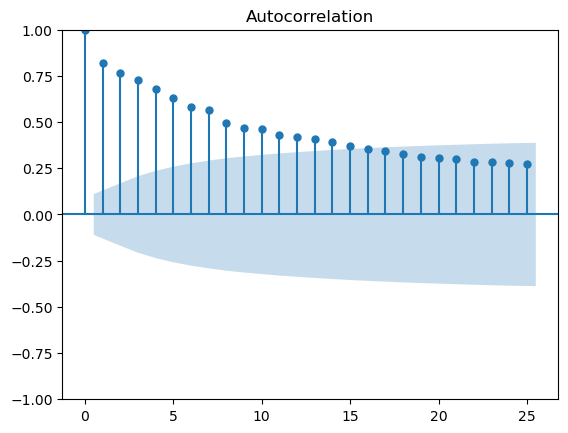

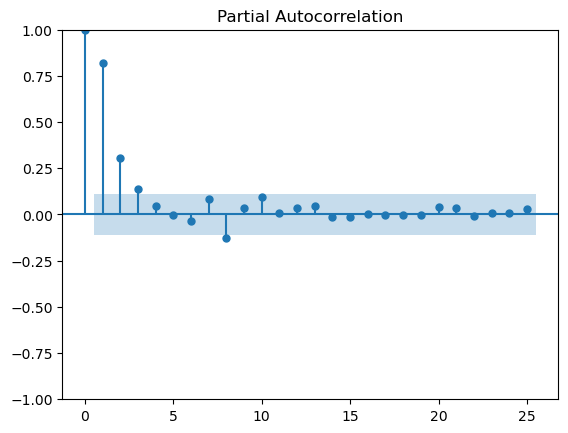

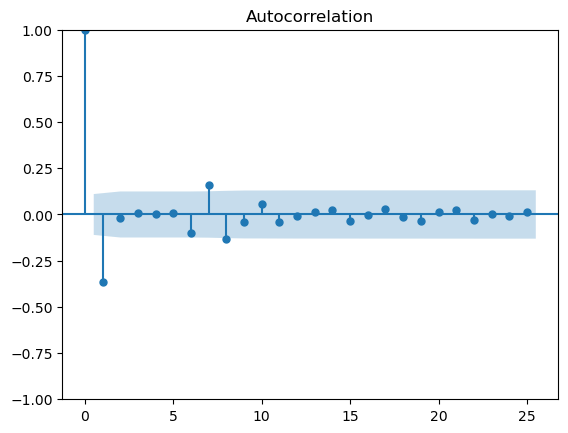

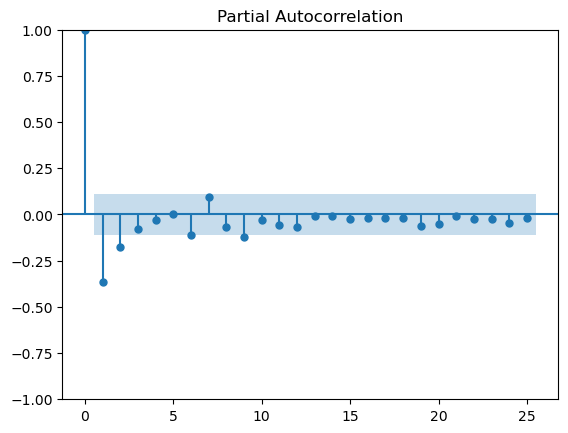

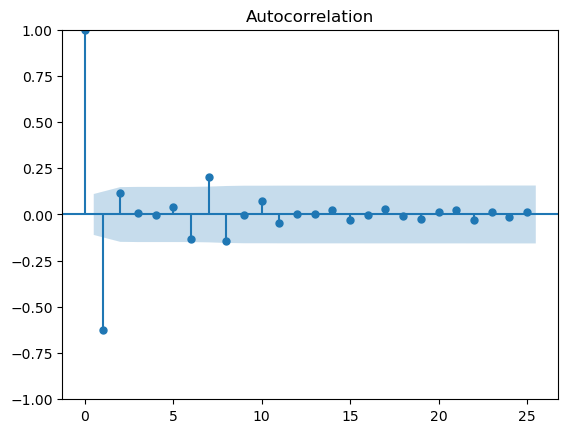

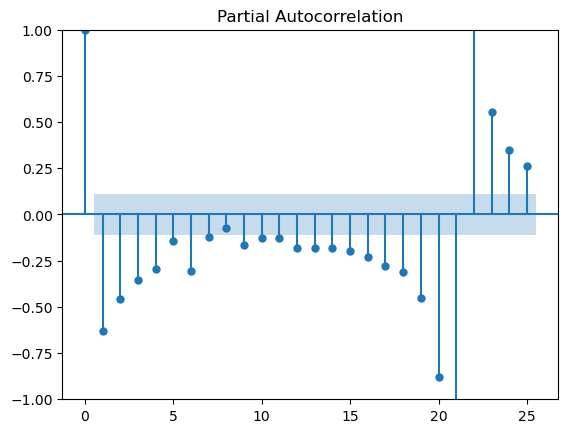

In [37]:
print("DADOS ORIGINAIS\n")
dickey_fuller_test(data_train)
kpss_test(data_train)
acf_plot=plot_acf(data_train)
pacf_plot=plot_pacf(data_train)


print("\n Primeira diferêncial\n")
dickey_fuller_test(data_train.diff().dropna())
kpss_test(data_train.diff().dropna())
acf_plot=plot_acf(data_train.diff().dropna())
pacf_plot=plot_pacf(data_train.diff().dropna())


print("\nSegunda diferêncial\n")
dickey_fuller_test(data_train.diff().diff().dropna())
kpss_test(data_train.diff().diff().dropna())
acf_plot=plot_acf(data_train.diff().diff().dropna())
pacf_plot=plot_pacf(data_train.diff().diff().dropna())

Dado que p-value menor que 0,05 podemos rejeitar a hipotese de que a serie é não estacionária para os dados originaís e para a segunda diferencial



In [38]:
best_model = SARIMAX(data_train, order=(0,2,2)).fit()
print(best_model.summary())

                               SARIMAX Results                                
Dep. Variable:                   data   No. Observations:                  315
Model:               SARIMAX(0, 2, 6)   Log Likelihood               -1145.375
Date:                Tue, 24 Jan 2023   AIC                           2304.750
Time:                        21:12:08   BIC                           2330.973
Sample:                    07-21-2020   HQIC                          2315.229
                         - 05-31-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.4513      4.703     -0.309      0.758     -10.669       7.766
ma.L2          0.4367      2.118      0.206      0.837      -3.715       4.588
ma.L3          0.0059      0.103      0.058      0.9

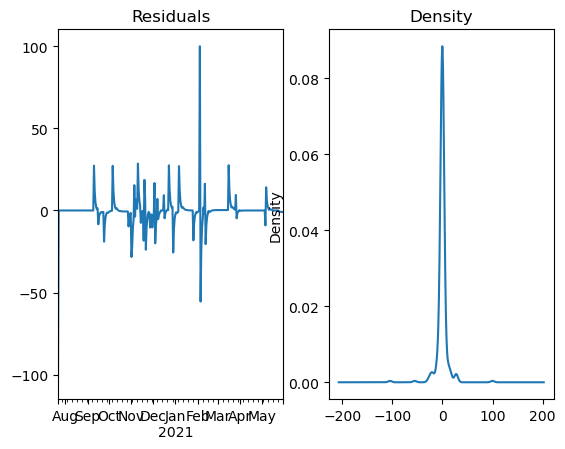

Figure(640x480)
Figure(640x480)


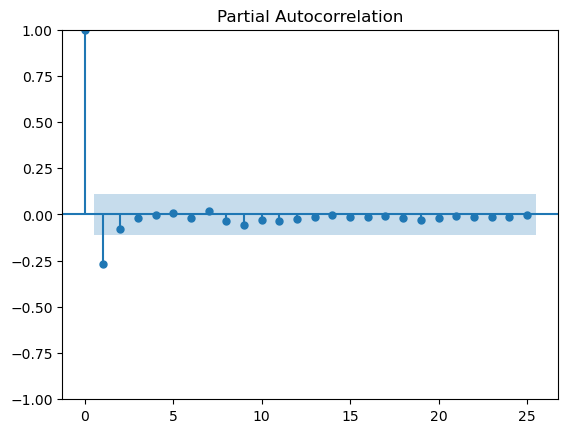

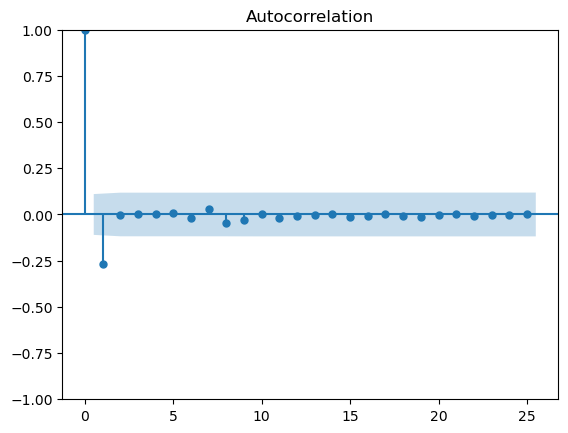

In [39]:
residuals = best_model.resid[1:]
fig, ax = plt.subplots(1,2)
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1])
plt.show()

print(plot_pacf(best_model.resid))
print(plot_acf(best_model.resid))

# Podemos verificar que os resíduos apresentam ser random e com uma distribuição de densidade gausiana , o que indica que são aproximadamente white noise 

In [40]:
## Use the model to predict the next 3 values in the time series

# Here we construct a more complete results object.
NN = len(data_test)
print(f"Forcast on {NN} next values")
print(best_model.forecast(steps=NN))
fcast = best_model.get_forecast(steps=NN)

# Most results are collected in the `summary_frame` attribute.
# Here we specify that we want a confidence level of 90%
print(); print("Statistics of confidence intervals")
print(fcast.summary_frame(alpha=0.10))

Forcast on 162 next values
2021-06-01    215.571445
2021-06-02    215.661175
2021-06-03    215.738578
2021-06-04    215.809454
2021-06-05    215.875562
                 ...    
2021-11-05    219.091102
2021-11-06    219.112119
2021-11-07    219.133135
2021-11-08    219.154152
2021-11-09    219.175169
Freq: D, Name: predicted_mean, Length: 162, dtype: float64

Statistics of confidence intervals
data              mean    mean_se  mean_ci_lower  mean_ci_upper
2021-06-01  215.571445   9.300044     200.274234     230.868656
2021-06-02  215.661175  10.622111     198.189357     233.132993
2021-06-03  215.738578  11.745143     196.419538     235.057619
2021-06-04  215.809454  12.744167     194.847164     236.771743
2021-06-05  215.875562  13.654875     193.415290     238.335833
...                ...        ...            ...            ...
2021-11-05  219.091102  68.616270     106.227382     331.954822
2021-11-06  219.112119  68.900575     105.780758     332.443479
2021-11-07  219.133135  69.

In [41]:
from sklearn.metrics import mean_squared_error
from math import sqrt

predictions = pd.Series(index=data_test.index)
history= data_train
for t,v in data_test.items():
 model = SARIMAX(history, order=(0,2,6)).fit()
 output = model.forecast()
 yhat =pd.Series(output[0], index=[t])
 predictions = predictions.append(yhat)
 obs= pd.Series([v], index=[t])
 history = history.append(obs)
 print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(data_test, predictions.dropna()))
print('Test RMSE: %.3f' % rmse)


predicted=215.571445, expected=214.579674
predicted=215.113708, expected=214.113177
predicted=214.651561, expected=213.646680
predicted=214.187279, expected=213.180182
predicted=213.721258, expected=212.713685
predicted=213.254066, expected=212.247188
predicted=212.786607, expected=211.780690
predicted=212.317921, expected=211.314193
predicted=211.848970, expected=210.847696
predicted=211.379684, expected=210.381198
predicted=210.910083, expected=209.914701
predicted=210.440519, expected=209.448204
predicted=209.970922, expected=208.981706
predicted=209.501012, expected=208.515209
predicted=209.031301, expected=208.048712
predicted=208.561202, expected=207.582214
predicted=208.091550, expected=207.115717
predicted=207.621838, expected=206.649220
predicted=207.152019, expected=206.182722
predicted=206.682423, expected=205.716225
predicted=206.212558, expected=205.249728
predicted=205.742758, expected=204.783230
predicted=205.273215, expected=204.316733
predicted=204.803347, expected=203

2020-07-26    209.220988
2020-07-27    209.219794
2020-07-28    209.219094
2020-07-29    209.218542
2020-07-30    209.218095
                 ...    
2021-05-27    217.746092
2021-05-28    217.331307
2021-05-29    216.893076
2021-05-30    216.462519
2021-05-31    216.021985
Freq: D, Length: 310, dtype: float64
2021-06-01    215.571445
2021-06-02    215.113708
2021-06-03    214.651561
2021-06-04    214.187279
2021-06-05    213.721258
                 ...    
2021-11-05    200.077078
2021-11-06    200.077170
2021-11-07    200.077240
2021-11-08    200.077347
2021-11-09    200.077416
Length: 162, dtype: float64


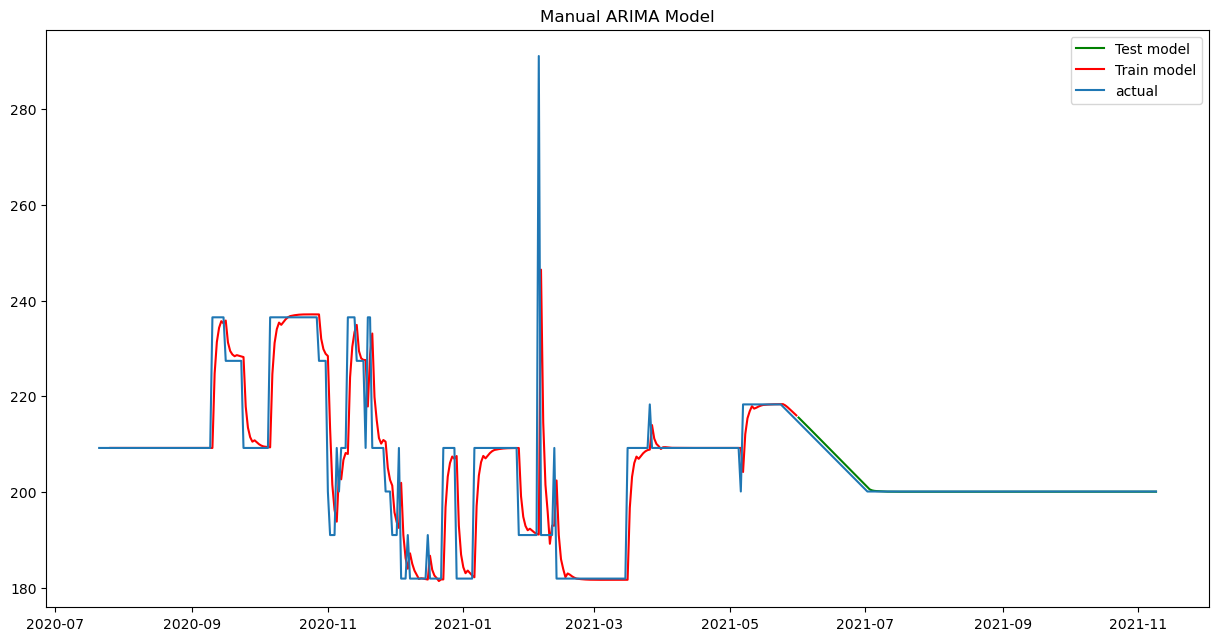

In [42]:
best_model = SARIMAX(data_train, order=(0,2,6)).fit()
arima_model = best_model.fittedvalues
arima_model[:4+1] = np.NaN
print(arima_model.dropna())
print(predictions.dropna())
data['Manual'] = arima_model.dropna().append(predictions.dropna())
plt.figure(figsize=(15, 7.5))
plt.plot(predictions.dropna(), color='g', label='Test model')
plt.plot(arima_model.dropna(), color='r', label='Train model')
plt.plot(data['data'], label='actual')
plt.title("Manual ARIMA Model")
plt.legend()
plt.show()

In [43]:

def optimize_ARIMA(order_list, exog):
    """
        Return dataframe with parameters and corresponding AIC
        
        order_list - list with (p, d, q) tuples
        exog - the exogenous variable
    """
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(exog, order=order).fit(disp=-1)
        except:
            continue

        aicc = model.aicc
        results.append([order, aicc])
        

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p, d, q)', 'AICc']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AICc', ascending=True).reset_index(drop=True)
    
    return result_df


In [81]:
## Set the grid search parameters
ps = range(0, 8, 1)
d = range(0,2,1)
qs = range(0, 8, 1)

# Create a list with all possible combination of parameters
parameters = product(ps,d, qs)
parameters_list = list(parameters)

order_list = []

for each in parameters_list:
    each = list(each)
    each = tuple(each)
    order_list.append(each)
    
result_df = optimize_ARIMA(order_list, exog=data_train)

result_df

  0%|          | 0/128 [00:00<?, ?it/s]

,"(p, d, q)",AICc
0,"(0, 1, 1)",2295.020053
1,"(3, 1, 1)",2295.141992
2,"(2, 1, 3)",2296.374431
3,"(4, 1, 1)",2296.539224
4,"(1, 1, 1)",2296.931388
...,...,...
123,"(0, 0, 4)",3394.803962
124,"(0, 0, 3)",3425.136786
125,"(0, 0, 2)",3617.390585
126,"(0, 0, 1)",3872.503905


In [86]:
import pmdarima as pm
auto_arima = pm.auto_arima(data_train, stepwise=False, seasonal=False)
auto_arima

ARIMA(order=(0, 1, 1), scoring_args={}, suppress_warnings=True)

In [87]:
optimize_model = SARIMAX(data_train, order=(0,1,1)).fit()
print(optimize_model.summary())

                               SARIMAX Results                                
Dep. Variable:                   data   No. Observations:                  315
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -1145.491
Date:                Tue, 24 Jan 2023   AIC                           2294.981
Time:                        21:45:29   BIC                           2302.480
Sample:                    07-21-2020   HQIC                          2297.978
                         - 05-31-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4550      0.016    -28.803      0.000      -0.486      -0.424
sigma2        86.2715      1.450     59.507      0.000      83.430      89.113
Ljung-Box (L1) (Q):                   0.02   Jarque-

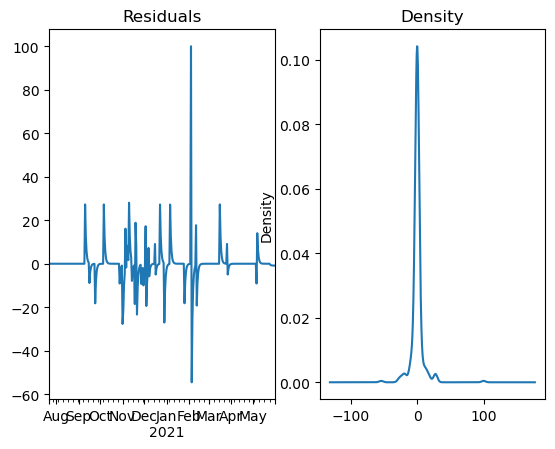

Figure(640x480)
Figure(640x480)


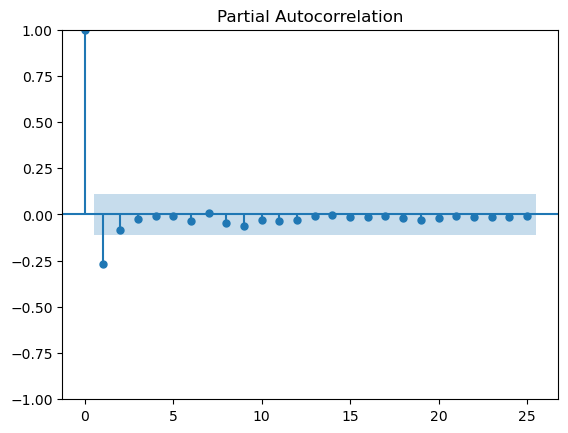

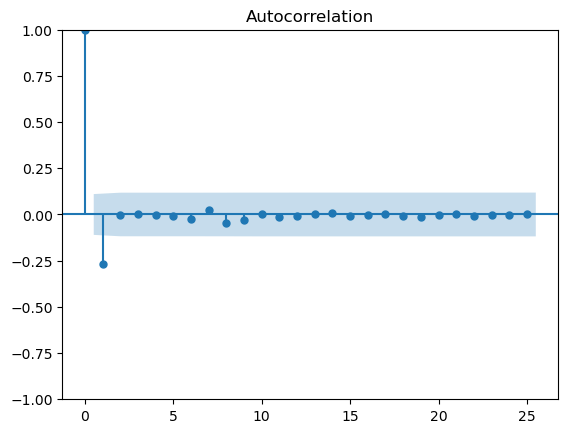

In [88]:
residuals = optimize_model.resid[1:]
fig, ax = plt.subplots(1,2)
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1])
plt.show()

print(plot_pacf(best_model.resid))
print(plot_acf(best_model.resid))

# Podemos verificar que os resíduos apresentam ser random e com uma distribuição de densidade gausiana , o que indica que são aproximadamente white noise 

In [89]:
from sklearn.metrics import mean_squared_error
from math import sqrt
predictions = pd.Series(index=data_test.index)
history= data_train
for t,v in data_test.items():
 model = SARIMAX(history, order=(0,2,2)).fit()
 output = model.forecast()
 yhat =pd.Series(output[0], index=[t])
 predictions = predictions.append(yhat)
 obs= pd.Series([v], index=[t])
 history = history.append(obs)
 print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(data_test, predictions.dropna()))
print('Test RMSE: %.3f' % rmse)


predicted=215.462936, expected=214.579674
predicted=214.994302, expected=214.113177
predicted=214.525348, expected=213.646680
predicted=214.056132, expected=213.180182
predicted=213.586948, expected=212.713685
predicted=213.117633, expected=212.247188
predicted=212.648414, expected=211.780690
predicted=212.179197, expected=211.314193
predicted=211.709954, expected=210.847696
predicted=211.240690, expected=210.381198
predicted=210.771583, expected=209.914701
predicted=210.302348, expected=209.448204
predicted=209.833152, expected=208.981706
predicted=209.363995, expected=208.515209
predicted=208.894897, expected=208.048712
predicted=208.425767, expected=207.582214
predicted=207.956617, expected=207.115717
predicted=207.487570, expected=206.649220
predicted=207.018499, expected=206.182722
predicted=206.549449, expected=205.716225
predicted=206.080409, expected=205.249728
predicted=205.611062, expected=204.783230
predicted=205.142380, expected=204.316733
predicted=204.673402, expected=203

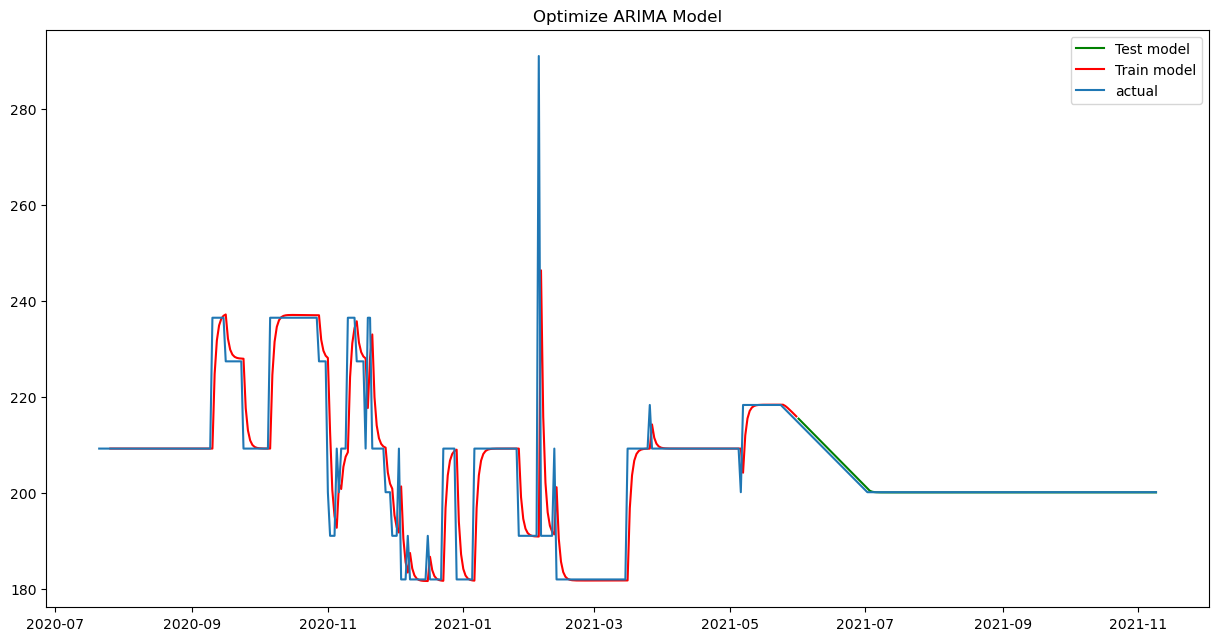

In [90]:
best_model = SARIMAX(data_train, order=(0,2,2)).fit()
arima_model = best_model.fittedvalues
arima_model[:4+1] = np.NaN

data['Manual'] = arima_model.dropna().append(predictions.dropna())
plt.figure(figsize=(15, 7.5))
plt.plot(predictions.dropna(), color='g', label='Test model')
plt.plot(arima_model.dropna(), color='r', label='Train model')
plt.plot(data['data'], label='actual')
plt.title("Optimize ARIMA Model")
plt.legend()
plt.show()

In [59]:
## Use the model to predict the next 3 values in the time series

# Here we construct a more complete results object.
NN = len(data_train)
print(f"Forcast on {NN} next values")
print(best_model.forecast(steps=NN))
fcast = best_model.get_forecast(steps=NN)

# Most results are collected in the `summary_frame` attribute.
# Here we specify that we want a confidence level of 90%
print(); print("Statistics of confidence intervals")
print(fcast.summary_frame(alpha=0.10))

Forcast on 315 next values
2021-06-01    215.462936
2021-06-02    215.482895
2021-06-03    215.502854
2021-06-04    215.522814
2021-06-05    215.542773
                 ...    
2022-04-07    221.650287
2022-04-08    221.670246
2022-04-09    221.690206
2022-04-10    221.710165
2022-04-11    221.730124
Freq: D, Name: predicted_mean, Length: 315, dtype: float64

Statistics of confidence intervals
data              mean     mean_se  mean_ci_lower  mean_ci_upper
2021-06-01  215.462936    9.318021     200.136156     230.789717
2021-06-02  215.482895   10.648093     197.968342     232.997449
2021-06-03  215.502854   11.836636     196.033320     234.972389
2021-06-04  215.522814   12.922762     194.266761     236.778866
2021-06-05  215.542773   13.930446     192.629228     238.456318
...                ...         ...            ...            ...
2022-04-07  221.650287  127.910559      11.256141     432.044434
2022-04-08  221.670246  128.217571      10.771109     432.569384
2022-04-09  221.69

## Multivariate/Multi-step

In [61]:
mv_data = data_wide.iloc[:, :-2]
print(mv_data.shape)
mv_data.head()

(507, 9)


,Abcdin,Falabella,Lider,Paris,Ripley,claro,entel,movistar,wom
2020-06-21,NaN,291.085236,NaN,NaN,NaN,209.214955,316.346766,272.89184,229.127627
2020-06-22,NaN,291.085236,NaN,NaN,NaN,209.214955,316.346766,272.89184,229.127627
2020-06-23,NaN,291.085236,NaN,NaN,NaN,209.214955,316.346766,272.89184,229.127627
2020-06-24,NaN,291.085236,NaN,NaN,NaN,209.214955,316.346766,272.89184,229.127627
2020-06-25,NaN,291.085236,NaN,NaN,NaN,209.214955,316.346766,272.89184,229.127627


Tendo em conta o número máximo de valores que estão em falta antes de aparecer um valor, removemos todos as entradas até aí, isto para que todas as séries temporais comecem ao mesmo tempo.

In [62]:
company_values = []
max_index = 0
for company in mv_data:
    company_price = mv_data[company]
    for i in range(len(company_price)):
        if (math.isnan(company_price[i]) == False and i > max_index):
            max_index = i
            break;
mv_data = mv_data[max_index:]
mv_data.shape

(384, 9)

In [63]:
mv_data = mv_data.interpolate(axis=0)
mv_data

,Abcdin,Falabella,Lider,Paris,Ripley,claro,entel,movistar,wom
2020-10-22,236.505049,291.085236,227.408351,227.408351,245.601747,218.311653,294.514691,227.408351,227.408351
2020-10-23,236.505049,291.085236,227.408351,227.408351,245.601747,218.311653,294.514691,227.408351,227.408351
2020-10-24,236.505049,291.085236,227.408351,300.181934,245.601747,218.311653,294.514691,227.408351,227.408351
2020-10-25,236.505049,291.085236,227.408351,300.181934,245.601747,218.311653,294.514691,227.408351,227.408351
2020-10-26,236.505049,291.085236,227.408351,300.181934,245.601747,218.311653,294.514691,227.408351,227.408351
...,...,...,...,...,...,...,...,...,...
2021-11-05,200.118257,209.214955,209.214955,191.021559,200.118257,218.311653,294.514691,191.021559,212.862731
2021-11-06,200.118257,209.214955,209.214955,191.021559,200.118257,218.311653,294.514691,191.021559,212.862731
2021-11-07,200.118257,209.214955,209.214955,191.021559,200.118257,218.311653,294.514691,191.021559,212.862731
2021-11-08,200.118257,209.214955,209.214955,191.021559,200.118257,218.311653,294.514691,191.021559,212.862731


In [64]:
mv_data=mv_data.drop(['claro', 'entel'], axis=1)
mv_data

,Abcdin,Falabella,Lider,Paris,Ripley,movistar,wom
2020-10-22,236.505049,291.085236,227.408351,227.408351,245.601747,227.408351,227.408351
2020-10-23,236.505049,291.085236,227.408351,227.408351,245.601747,227.408351,227.408351
2020-10-24,236.505049,291.085236,227.408351,300.181934,245.601747,227.408351,227.408351
2020-10-25,236.505049,291.085236,227.408351,300.181934,245.601747,227.408351,227.408351
2020-10-26,236.505049,291.085236,227.408351,300.181934,245.601747,227.408351,227.408351
...,...,...,...,...,...,...,...
2021-11-05,200.118257,209.214955,209.214955,191.021559,200.118257,191.021559,212.862731
2021-11-06,200.118257,209.214955,209.214955,191.021559,200.118257,191.021559,212.862731
2021-11-07,200.118257,209.214955,209.214955,191.021559,200.118257,191.021559,212.862731
2021-11-08,200.118257,209.214955,209.214955,191.021559,200.118257,191.021559,212.862731


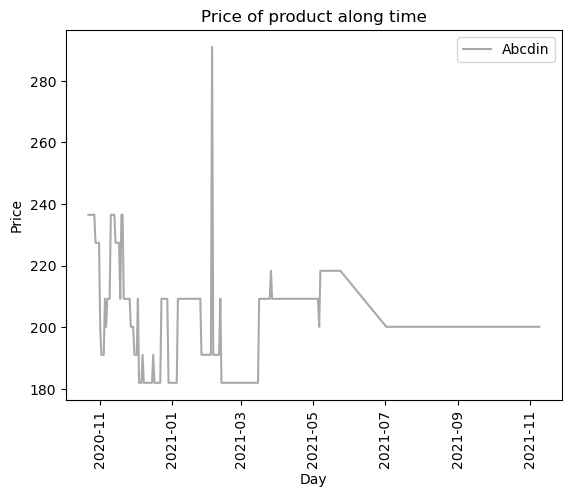

ADF Test Statistic:  -3.830577237264575
P-value:  0.0026095145833190335
Reject the null hypothesis - Time Series is stationary
KPSS Test Statistic:  0.1644747062004622
P-value:  0.1
Failed to reject the null hypothesis - Time Series is not stationary


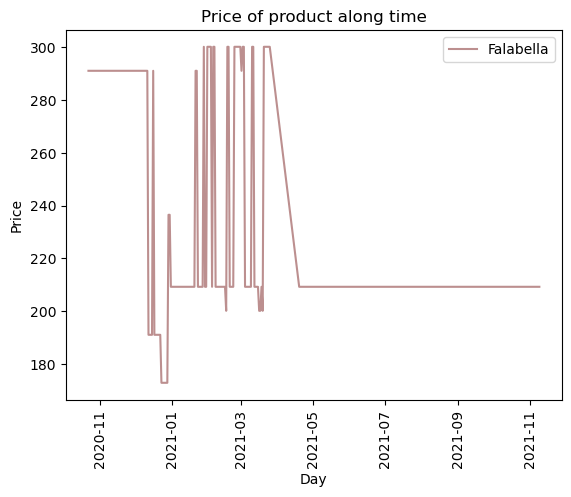

ADF Test Statistic:  -3.251324524983737
P-value:  0.017199508159973363
Reject the null hypothesis - Time Series is stationary
KPSS Test Statistic:  1.4532177406857243
P-value:  0.01
Reject the null hypothesis - Time Series is stationary


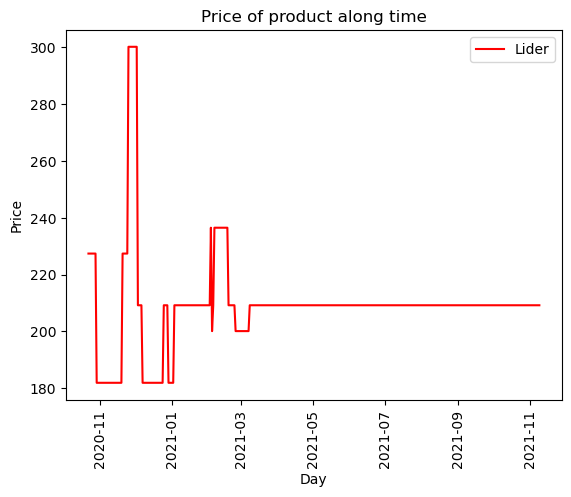

ADF Test Statistic:  -6.052736112072582
P-value:  1.2661600249739925e-07
Reject the null hypothesis - Time Series is stationary
KPSS Test Statistic:  0.022281460008268708
P-value:  0.1
Failed to reject the null hypothesis - Time Series is not stationary


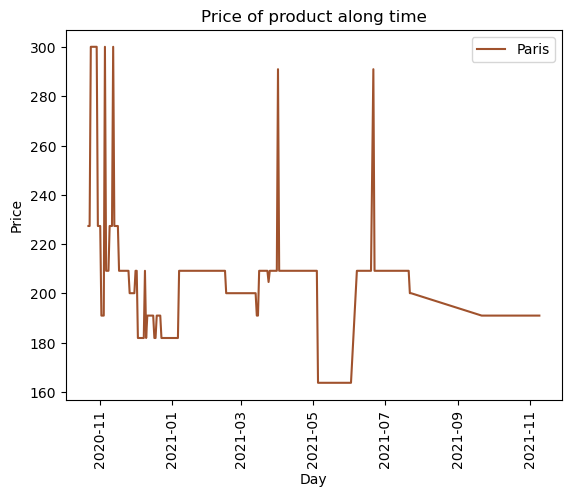

ADF Test Statistic:  -5.93897529536175
P-value:  2.284879156221492e-07
Reject the null hypothesis - Time Series is stationary
KPSS Test Statistic:  0.5500627274597493
P-value:  0.030391277599155567
Reject the null hypothesis - Time Series is stationary


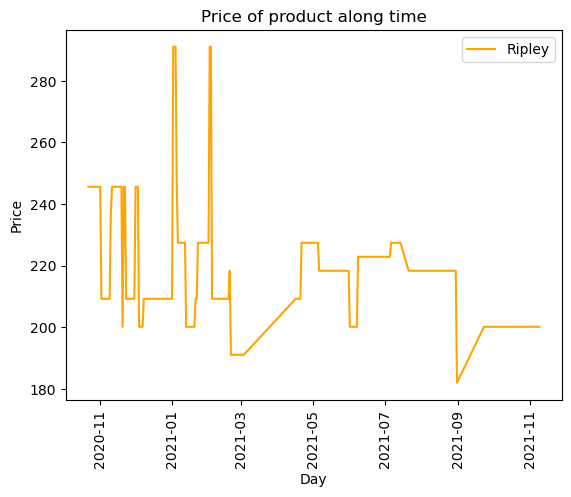

ADF Test Statistic:  -5.16539519562833
P-value:  1.0340878374392794e-05
Reject the null hypothesis - Time Series is stationary
KPSS Test Statistic:  0.6818193790130784
P-value:  0.015198238271538322
Reject the null hypothesis - Time Series is stationary


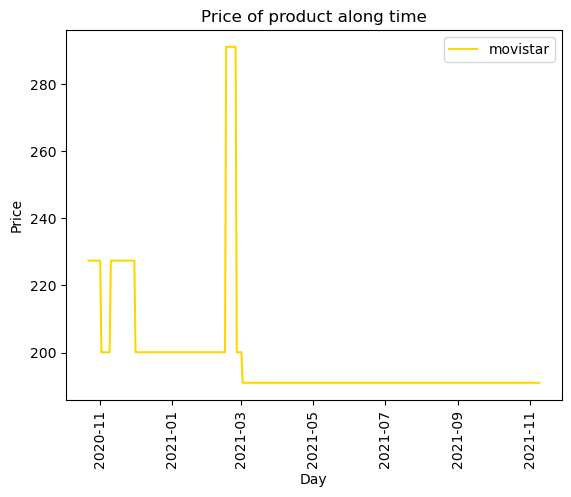

ADF Test Statistic:  -3.4796690154666425
P-value:  0.008524849274022205
Reject the null hypothesis - Time Series is stationary
KPSS Test Statistic:  1.1807161044357533
P-value:  0.01
Reject the null hypothesis - Time Series is stationary


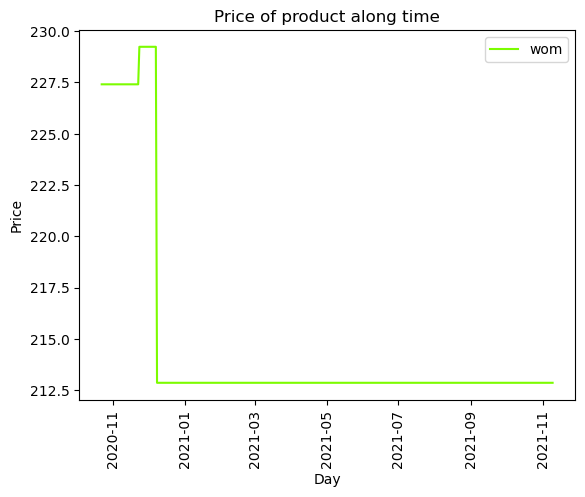

ADF Test Statistic:  -2.637630282708992
P-value:  0.08546654677507193
Failed to reject the null hypothesis - Time Series is not stationary
KPSS Test Statistic:  1.2489067720038736
P-value:  0.01
Reject the null hypothesis - Time Series is stationary


In [65]:
colors = ["darkgray", "rosybrown", "red", "sienna", "orange", "gold", "lawngreen", "green", "cyan", "royalblue", "darkviolet"]

legend = []
for company, color in zip(mv_data.columns, colors):

    plt.figure()
    plt.plot(mv_data[company], color=color)
    plt.title("Price of product along time")
    plt.legend([company])
    plt.ylabel('Price')
    plt.xlabel('Day')
    plt.xticks(rotation=90)
    plt.savefig("figures/mv_"+company+"_data_plots.jpeg", bbox_inches="tight")
    plt.show()
    adf=dickey_fuller_test(mv_data[company])
    kpss_value=kpss_test(mv_data[company])
    

In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(mv_data, variables = mv_data.columns)  

c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 6, but rank is 1
  warnings.warn('covariance of constraints does not have full '
c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 7, but rank is 1
  warnings.warn('covariance of constraints does not have full '
c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 6, but rank is 1
  warnings.warn('covariance of constraints does not have full '
c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 7, but rank is 1
  warnings.warn('covariance of constraints does not have full '


,Abcdin_x,Falabella_x,Lider_x,Paris_x,Ripley_x,movistar_x,wom_x
Abcdin_y,1.0000,0.0000,0.0000,0.2187,0.0000,0.2646,0.1905
Falabella_y,0.0033,1.0000,0.0606,0.0114,0.0664,0.0000,0.0000
Lider_y,0.0020,0.0313,1.0000,0.1962,0.0000,0.8896,0.0310
Paris_y,0.0934,0.0105,0.2689,1.0000,0.1476,0.0933,0.0189
Ripley_y,0.0250,0.0127,0.0006,0.0266,1.0000,0.2341,0.1462
movistar_y,0.0000,0.0025,0.0180,0.1541,0.3098,1.0000,0.1839
wom_y,0.0016,0.8315,0.0000,0.0312,0.0000,0.0527,1.0000


In [ ]:
mv_matrix = mv_data.to_numpy()

In [ ]:
print(mv_matrix.shape)

### Multistep

In [ ]:
min_error = 1000000000000000
best_steps = 0
best_n_layers = 0
for n_steps in range (3,20,4):
    X, y = multi_split_sequences(mv_matrix, n_steps)
    train_ind = int(X.shape[0]*0.7)
    n_features = X[0].shape[1]
    X_train = X[:train_ind]
    y_train = y[:train_ind]
    X_test = X[train_ind:]
    y_test = y[train_ind:]
    for num_layers in range(2,6):
        model = Sequential()
        model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
        for k in range(num_layers-1):
            model.add(LSTM(100, activation='relu', return_sequences=True))
            n_layer = k+1
        model.add(LSTM(100, activation='relu'))
        model.add(Dense(n_features))
        model.compile(optimizer='adam', loss='mse')
        model.fit(X_train, y_train, epochs=200, verbose=0)
        mspe = np.zeros((X.shape[0],X.shape[2]))
        for i in range(X_test.shape[0]):
            x_input = X_test[i,:].reshape((1, n_steps, n_features))
            yhat = model.predict(x_input, verbose=0)
            for j in range(yhat.shape[1]):
                mspe[i][j] = (yhat[0][j]-y_test[i][j])**2
        error = np.sum(mspe)
        if error < min_error:
            model.save("best_multi_stacked_lstm")
            min_error = error
            best_steps = n_steps
            best_n_layers = n_layer
            best_steps = n_steps
            best_X_train = X_train
            best_X_test = X_test
            best_y_train = y_train
            best_y_test = y_test
        print("Steps: ",n_steps, "\tNúmero de layers: ", num_layers,"\tErro: ", error)


In [ ]:
plt.plot(X_test,best_y_test)
plt.plot(X_test,predictions)
plt.title('Stacked Model')
plt.ylabel('Price')
plt.xlabel('Time')
plt.legend(['Real Value', 'Prediction'], loc='upper left')
plt.savefig('figures/stacked_lstm.png')
plt.show()

## VARMA

In [68]:
from statsmodels.tsa.api import VAR

model = VAR(mv_data)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  27.18892597515479
BIC :  27.76618435477389
FPE :  642715827005.2662
HQIC:  27.417915066649197 

Lag Order = 2
AIC :  27.044888129124054
BIC :  28.129362380180833
FPE :  556632423795.4426
HQIC:  27.475124957132827 

Lag Order = 3
AIC :  26.85902571999647
BIC :  28.452703157711724
FPE :  462506285498.72797
HQIC:  27.4913394514164 

Lag Order = 4
AIC :  26.907727428144973
BIC :  29.012608386835097
FPE :  486162566337.69763
HQIC:  27.742952725865006 

Lag Order = 5
AIC :  26.75100426865062
BIC :  29.36910222031493
FPE :  416447182036.51416
HQIC:  27.78998134144295 

Lag Order = 6
AIC :  26.33950477283241
BIC :  29.47284644712208
FPE :  276763252409.6395
HQIC:  27.58307942581726 

Lag Order = 7
AIC :  26.21903737599703
BIC :  29.86966288158537
FPE :  246355227762.79315
HQIC:  27.668061061689095 

Lag Order = 8
AIC :  25.974055523873716
BIC :  30.14401847124757
FPE :  193887023806.68808
HQIC:  27.62938539381833 

Lag Order = 9
AIC :  25.74464072728189
BIC :  30.436008352

In [69]:
x = model.select_order(maxlags=12)
x.summary()

,AIC,BIC,FPE,HQIC
0,36.85,36.93,1.012e+16,36.88
1,26.97,27.56*,5.172e+11,27.21
2,26.72,27.83,4.036e+11,27.16
3,26.60,28.22,3.567e+11,27.24
4,26.64,28.78,3.712e+11,27.49
5,26.48,29.13,3.164e+11,27.53
6,26.05,29.22,2.070e+11,27.31
7,25.93,29.62,1.854e+11,27.40
8,25.81,30.02,1.649e+11,27.48
9,25.60,30.32,1.345e+11,27.47


In [70]:
model_fitted = model.fit(4)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 24, Jan, 2023
Time:                     21:31:45
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                    29.0126
Nobs:                     380.000    HQIC:                   27.7430
Log likelihood:          -8683.84    FPE:                4.86163e+11
AIC:                      26.9077    Det(Omega_mle):     2.90538e+11
--------------------------------------------------------------------
Results for equation Abcdin
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const               35.243507        21.244334            1.659           0.097
L1.Abcdin            0.499272         0.056598            8.821           0.000
L1.Falabella         0.030259         0.021621            1.400

In [72]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(mv_data.columns, out):
    print(adjust(col), ':', round(val, 2))

NameError: name 'adjust' is not defined

In [73]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = mv_data.values[-lag_order:]
forecast_input

4


array([[200.11825707, 209.21495497, 209.21495497, 191.02155917,
        200.11825707, 191.02155917, 212.86273083],
       [200.11825707, 209.21495497, 209.21495497, 191.02155917,
        200.11825707, 191.02155917, 212.86273083],
       [200.11825707, 209.21495497, 209.21495497, 191.02155917,
        200.11825707, 191.02155917, 212.86273083],
       [200.11825707, 209.21495497, 209.21495497, 191.02155917,
        200.11825707, 191.02155917, 212.86273083]])

In [75]:
# Forecast
nobs=4
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=mv_data.index[-nobs:], columns=mv_data.columns + '_2d')
df_forecast

,Abcdin_2d,Falabella_2d,Lider_2d,Paris_2d,Ripley_2d,movistar_2d,wom_2d
2021-11-06,199.860491,211.609564,209.023326,191.645595,202.229246,191.335727,212.769185
2021-11-07,200.027366,213.117794,208.996518,192.112314,204.029747,191.613030,212.680815
2021-11-08,200.585515,213.558126,208.329166,192.478359,205.364966,191.746480,212.603615
2021-11-09,200.603812,214.478601,207.890376,192.453551,206.366732,191.902968,212.527258


In [76]:
df_results = invert_transformation(train, df_forecast, second_diff=True)        
df_results.loc[:, ['rgnp_forecast', 'pgnp_forecast', 'ulc_forecast', 'gdfco_forecast',
                   'gdf_forecast', 'gdfim_forecast', 'gdfcf_forecast', 'gdfce_forecast']]

NameError: name 'invert_transformation' is not defined

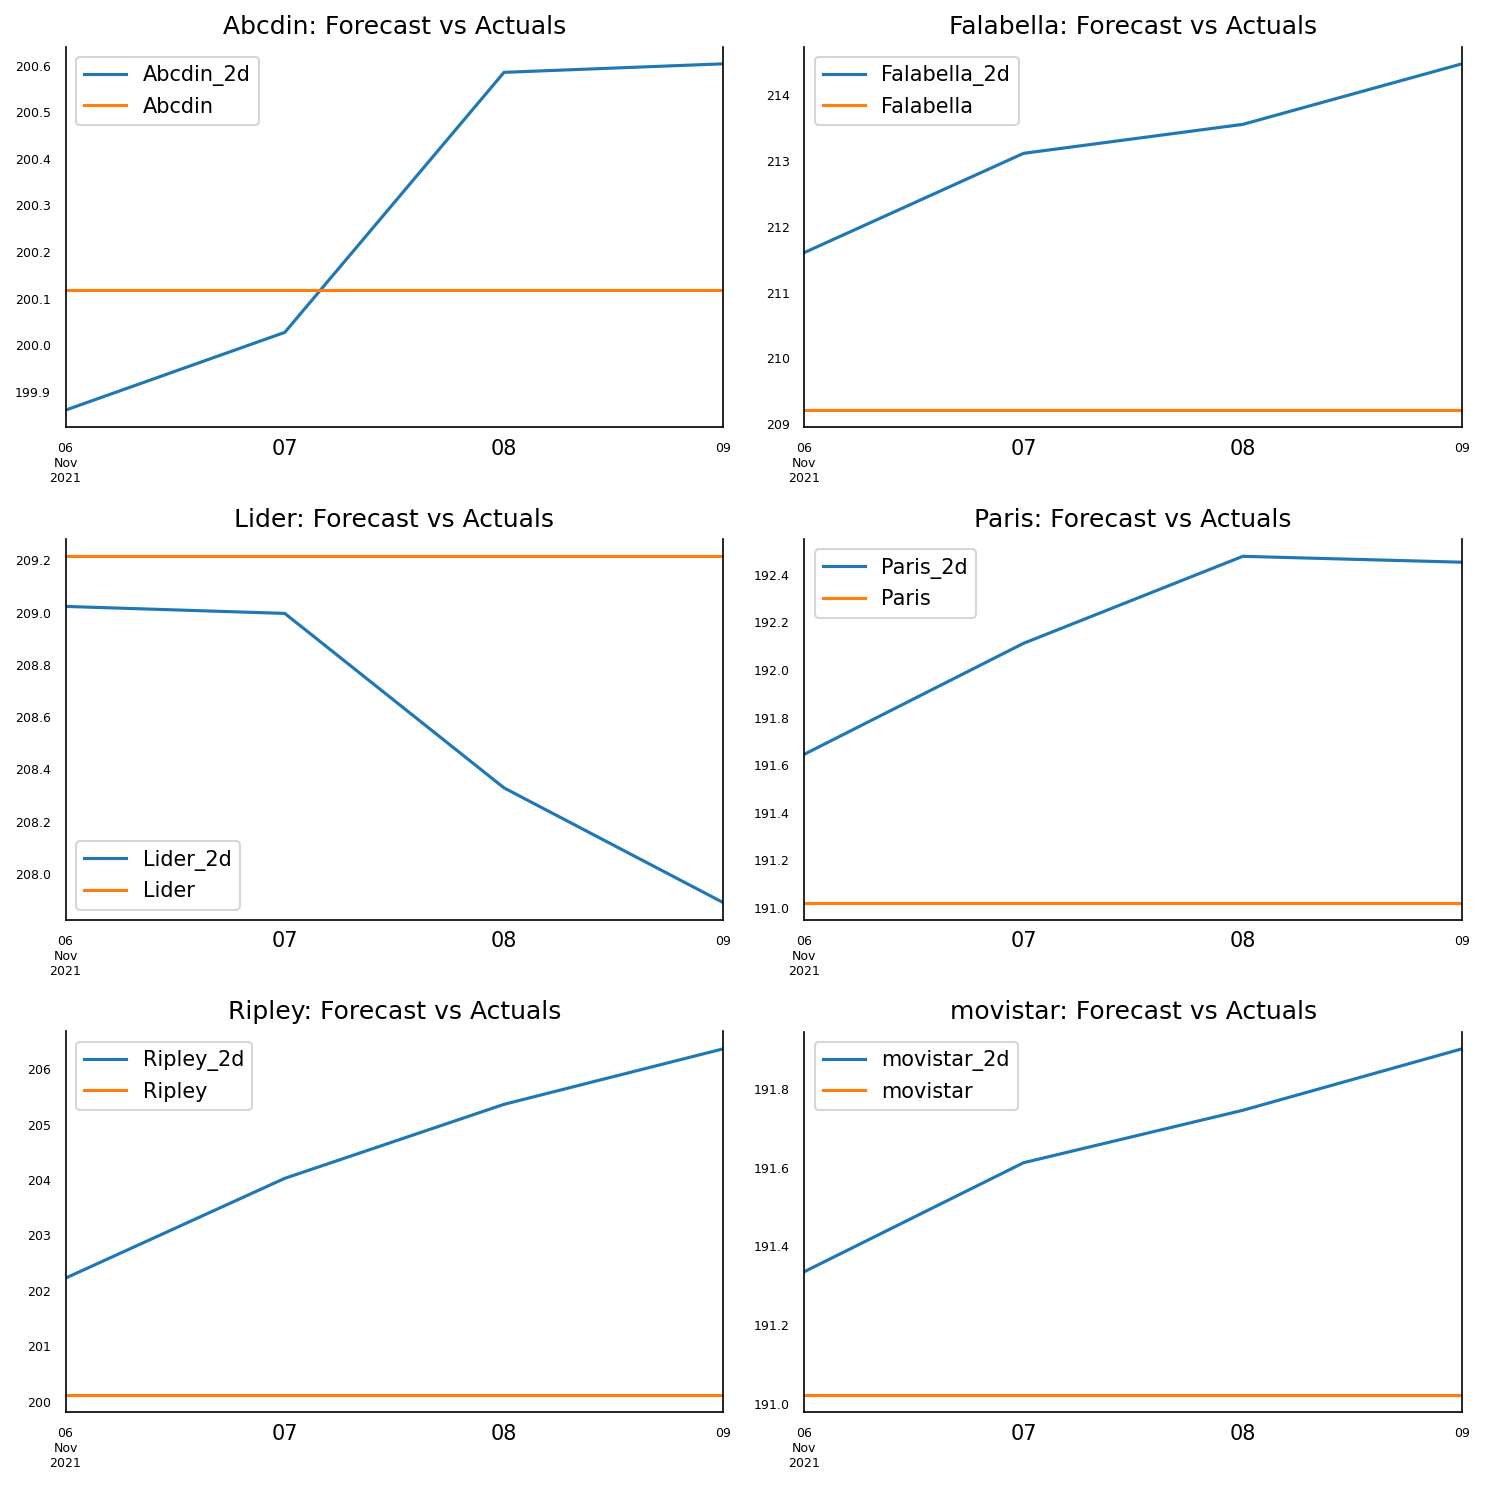

In [80]:
fig, axes = plt.subplots(nrows=int(len(mv_data.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(mv_data.columns, axes.flatten())):
    df_forecast[col+'_2d'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    mv_data[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();